In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Start
repo - https://github.com/peteryuX/retinaface-tf2

Dataset - http://shuoyang1213.me/WIDERFACE/

Training dataset download link - https://drive.google.com/file/d/15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M/view

Validation dataset download link - https://drive.google.com/file/d/1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q/view

RetinaFace official annotations - http://shuoyang1213.me/WIDERFACE/support/bbx_annotation/wider_face_split.zip

In [2]:
import os
import cv2
import json
import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model

from google_drive_downloader import GoogleDriveDownloader as gdd

# Configuration

In [3]:
cfg = {
'batch_size': 8,
'input_size': 640,
'backbone_type': 'MobileNetV2',  # 'ResNet50', 'MobileNetV2'
'sub_name': 'retinaface_mbv2',

# training dataset
'dataset_path': '/content/drive/MyDrive/RetinaFace/widerface_train_bin_onlybbox.tfrecord',
'dataset_len': 12880,  # number of training samples
'using_bin': True,            #using binary or not
'using_flip': False,
'using_distort': False,

# testing dataset
'testing_dataset_path': './data/widerface/val',

# network
'out_channel': 64,

# anchor setting
'min_sizes': [[16, 32], [64, 128], [256, 512]],
'steps': [8, 16, 32],
'match_thresh': 0.45,
'ignore_thresh': 0.3,
'variances': [0.1, 0.2],
'clip': False,

# training setting
'epoch': 1,
'init_lr': float(1e-2),
'lr_decay_epoch': [50, 68],
'lr_rate': 0.1,
'warmup_epoch': 5,
'min_lr': float(1e-3),

'weights_decay': float(5e-4),
'momentum': 0.9,

'pretrain': True,

'save_steps': 1000
}

#Download Dataset and annotations

In [9]:
!mkdir data

In [10]:
#training images
gdd.download_file_from_google_drive(file_id='15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M',
                                    dest_path='/content/data/widertrain.zip',
                                    unzip=True)

Unzipping...Done.


In [11]:
#validation images
gdd.download_file_from_google_drive(file_id='1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q',
                                    dest_path='/content/data/widerval.zip',
                                    unzip=True)

Unzipping...Done.


In [12]:
#testing images
gdd.download_file_from_google_drive(file_id='1HIfDbVEWKmsYKJZm4lchTBDLW5N7dY5T',
                                    dest_path='/content/data/widertest.zip',
                                    unzip=True)

Unzipping...Done.


In [13]:
!mkdir labels

In [14]:
#ground truth labels
gdd.download_file_from_google_drive(file_id='1vgCABX1JI3NGBzsHxwBXlmRjaLV3NIsG',
                                    dest_path='/content/labels/widergt.zip',
                                    unzip=True)

Unzipping...Done.


In [15]:
!cp /content/labels/train/label.txt /content/data/WIDER_train/

In [16]:
!cp /content/labels/val/label.txt /content/data/WIDER_val/

From official site as well http://shuoyang1213.me/WIDERFACE/

In [17]:
# !wget http://shuoyang1213.me/WIDERFACE/support/bbx_annotation/wider_face_split.zip

In [18]:
#!unzip /content/wider_face_split.zip

In [19]:
!cp /content/wider_face_split/wider_face_train_bbx_gt.txt /content/data/WIDER_train
!cp /content/wider_face_split/wider_face_val_bbx_gt.txt /content/data/WIDER_val

cp: cannot stat '/content/wider_face_split/wider_face_train_bbx_gt.txt': No such file or directory
cp: cannot stat '/content/wider_face_split/wider_face_val_bbx_gt.txt': No such file or directory


In [20]:
!mkdir /content/data/widerface
!mkdir /content/data/widerface/train
!mkdir /content/data/widerface/val

# Preparing Data

In [ ]:
# train_folder = '/content/data/WIDER_train/images/'
# for root, dirs, files in os.walk(train_folder):
#   print(root)
#   print(dirs)
#   print(files)


In [21]:
train_folder = '/content/data/WIDER_train/images/'
train_images = []
for root, dirs, files in os.walk(train_folder):
  if (len(files)>0) and ('.jpg' in files[0]):
    temp = [os.path.join(root, i) for i in files]
    train_images+=temp
  
len(train_images)

12880

In [22]:
train_images[:2]

['/content/data/WIDER_train/images/46--Jockey/46_Jockey_Jockey_46_783.jpg',
 '/content/data/WIDER_train/images/46--Jockey/46_Jockey_Jockey_46_304.jpg']

In [23]:
test_folder = '/content/data/WIDER_test/images/'
test_images = []
for root, dirs, files in os.walk(test_folder):
  if (len(files)>0) and ('.jpg' in files[0]):
    temp = [os.path.join(root, i) for i in files]
    test_images+=temp
  
len(test_images)

16097

In [24]:
test_images[:2]

['/content/data/WIDER_test/images/46--Jockey/46_Jockey_Jockey_46_143.jpg',
 '/content/data/WIDER_test/images/46--Jockey/46_Jockey_Jockey_46_543.jpg']

# Datasets

## Priors

In [55]:
import math
import tensorflow as tf
import numpy as np
from itertools import product as product


###############################################################################
#   Tensorflow / Numpy Priors                                                 #
###############################################################################
def prior_box(image_sizes, min_sizes, steps, clip=False):
    """prior box"""
    feature_maps = [
        [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
        for step in steps]

    anchors = []
    for k, f in enumerate(feature_maps):
        for i, j in product(range(f[0]), range(f[1])):
            for min_size in min_sizes[k]:
                s_kx = min_size / image_sizes[1]
                s_ky = min_size / image_sizes[0]
                cx = (j + 0.5) * steps[k] / image_sizes[1]
                cy = (i + 0.5) * steps[k] / image_sizes[0]
                anchors += [cx, cy, s_kx, s_ky]

    output = np.asarray(anchors).reshape([-1, 4])

    if clip:
        output = np.clip(output, 0, 1)

    return output


def prior_box_tf(image_sizes, min_sizes, steps, clip=False):
    """prior box"""
    image_sizes = tf.cast(tf.convert_to_tensor(image_sizes), tf.float32)
    feature_maps = tf.math.ceil(
        tf.reshape(image_sizes, [1, 2]) /
        tf.reshape(tf.cast(steps, tf.float32), [-1, 1]))

    anchors = []
    for k in range(len(min_sizes)):
        grid_x, grid_y = _meshgrid_tf(tf.range(feature_maps[k][1]),
                                      tf.range(feature_maps[k][0]))
        cx = (grid_x + 0.5) * steps[k] / image_sizes[1]
        cy = (grid_y + 0.5) * steps[k] / image_sizes[0]
        cxcy = tf.stack([cx, cy], axis=-1)
        cxcy = tf.reshape(cxcy, [-1, 2])
        cxcy = tf.repeat(cxcy, repeats=tf.shape(min_sizes[k])[0], axis=0)

        sx = min_sizes[k] / image_sizes[1]
        sy = min_sizes[k] / image_sizes[0]
        sxsy = tf.stack([sx, sy], 1)
        sxsy = tf.repeat(sxsy[tf.newaxis],
                         repeats=tf.shape(grid_x)[0] * tf.shape(grid_x)[1],
                         axis=0)
        sxsy = tf.reshape(sxsy, [-1, 2])

        anchors.append(tf.concat([cxcy, sxsy], 1))

    output = tf.concat(anchors, axis=0)

    if clip:
        output = tf.clip_by_value(output, 0, 1)

    return output

def _meshgrid_tf(x, y):
    """ workaround solution of the tf.meshgrid() issue:
        https://github.com/tensorflow/tensorflow/issues/34470"""
    grid_shape = [tf.shape(y)[0], tf.shape(x)[0]]
    grid_x = tf.broadcast_to(tf.reshape(x, [1, -1]), grid_shape)
    grid_y = tf.broadcast_to(tf.reshape(y, [-1, 1]), grid_shape)
    return grid_x, grid_y


# Post processing model output - functions

## Decoding

In [50]:
###############################################################################
#   Tensorflow Decoding                                                       #
###############################################################################
def decode_tf(labels, priors, variances=[0.1, 0.2]):
    """tensorflow decoding"""
    bbox = _decode_bbox(labels[:, :4], priors, variances)
    
    #dummy data for landm
    #landm = tf.concat([labels[:, :4],labels[:, :4]], axis=1) 
    #landm = _decode_landm(landm, priors, variances)
    #

    landm_valid = labels[:, 4][:, tf.newaxis]
    conf = labels[:, 5][:, tf.newaxis]

    return tf.concat(
        [bbox, 
         #landm, 
         landm_valid, 
         conf], 
         axis=1)


def _decode_bbox(pre, priors, variances=[0.1, 0.2]):
    """Decode locations from predictions using priors to undo
    the encoding we did for offset regression at train time.
    Args:
        pre (tensor): location predictions for loc layers,
            Shape: [num_priors,4]
        priors (tensor): Prior boxes in center-offset form.
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        decoded bounding box predictions
    """
    centers = priors[:, :2] + pre[:, :2] * variances[0] * priors[:, 2:]
    sides = priors[:, 2:] * tf.math.exp(pre[:, 2:] * variances[1])

    return tf.concat([centers - sides / 2, centers + sides / 2], axis=1)


def _decode_landm(pre, priors, variances=[0.1, 0.2]):
    """Decode landm from predictions using priors to undo
    the encoding we did for offset regression at train time.
    Args:
        pre (tensor): landm predictions for loc layers,
            Shape: [num_priors,10]
        priors (tensor): Prior boxes in center-offset form.
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        decoded landm predictions
    """
    landms = tf.concat(
        [priors[:, :2] + pre[:, :2] * variances[0] * priors[:, 2:],
         priors[:, :2] + pre[:, 2:4] * variances[0] * priors[:, 2:],
         priors[:, :2] + pre[:, 4:6] * variances[0] * priors[:, 2:],
         priors[:, :2] + pre[:, 6:8] * variances[0] * priors[:, 2:],
         priors[:, :2] + pre[:, 8:10] * variances[0] * priors[:, 2:]], axis=1)
    return landms

## Padding

In [51]:
###############################################################################
#   Testing                                                                   #
###############################################################################
def pad_input_image(img, max_steps):
    """pad image to suitable shape"""
    img_h, img_w, _ = img.shape

    img_pad_h = 0
    if img_h % max_steps > 0:
        img_pad_h = max_steps - img_h % max_steps

    img_pad_w = 0
    if img_w % max_steps > 0:
        img_pad_w = max_steps - img_w % max_steps

    padd_val = np.mean(img, axis=(0, 1)).astype(np.uint8)
    img = cv2.copyMakeBorder(img, 0, img_pad_h, 0, img_pad_w,
                             cv2.BORDER_CONSTANT, value=padd_val.tolist())
    pad_params = (img_h, img_w, img_pad_h, img_pad_w)

    return img, pad_params


def recover_pad_output(outputs, pad_params):
    """recover the padded output effect"""
    img_h, img_w, img_pad_h, img_pad_w = pad_params
    recover_xy = np.reshape(outputs[:, :14], [-1, 7, 2]) * \
        [(img_pad_w + img_w) / img_w, (img_pad_h + img_h) / img_h]
    outputs[:, :14] = np.reshape(recover_xy, [-1, 14])

    return outputs

def pad_landm(outputs):
  output = []
  for o in outputs:
    temp = list(o[:4])+ [0,0,0,0,0,0,0,0,0,0] + list(o[4:])
    output.append(temp)
  return np.array(output)

def recover_pad_landm(outputs):
  output = []
  for o in outputs:
    temp = list(o[:4]) + list(o[14:])
    output.append(temp)
  return np.array(output)

In [52]:
#padding input image to square for testing tflite
def _pad_to_square(img):
    height = tf.shape(img)[0]
    width = tf.shape(img)[1]

    def pad_h():
        img_pad_h = tf.ones([width - height, width, 3]) * \
            tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_h], axis=0)

    def pad_w():
        img_pad_w = tf.ones([height, height - width, 3]) * \
            tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_w], axis=1)

    img = tf.case([(tf.greater(height, width), pad_w),
                   (tf.less(height, width), pad_h)], default=lambda: img)

    return img

## Visualization

In [53]:
###############################################################################
#   Visulization                                                              #
###############################################################################
def draw_bbox(img, ann, img_height, img_width):
    """draw bboxes and landmarks"""
    # bbox
    x1, y1, x2, y2 = int(ann[0] * img_width), int(ann[1] * img_height), \
                     int(ann[2] * img_width), int(ann[3] * img_height)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # confidence
    text = "{:.4f}".format(ann[5])
    cv2.putText(img, text, (int(ann[0] * img_width), int(ann[1] * img_height)),
                cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))



def draw_anchor(img, prior, img_height, img_width):
    """draw anchors"""
    x1 = int(prior[0] * img_width - prior[2] * img_width / 2)
    y1 = int(prior[1] * img_height - prior[3] * img_height / 2)
    x2 = int(prior[0] * img_width + prior[2] * img_width / 2)
    y2 = int(prior[1] * img_height + prior[3] * img_height / 2)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 0), 1)

## Prediction

In [48]:
def predict_image(img_path, iou_th = .3, score_th = .5):
  """Predict results on single image"""

  #raw image
  img_raw = plt.imread(img_path)
  img_height_raw, img_width_raw, _ = img_raw.shape

  # pad input image to avoid unmatched shape problem
  img, pad_params = pad_input_image(img_raw, max_steps=max(cfg['steps']))
  img = np.expand_dims(img, axis=0)

  #model output
  model_output = loaded_model(img)

  #preds
  preds = tf.concat(
      [model_output[0][0],
      tf.ones_like(model_output[1][0, :, 0][..., tf.newaxis]),
      model_output[1][0, :, 1][..., tf.newaxis]],
      axis = 1
  )

  #making priors
  priors = prior_box_tf((img.shape[1], img.shape[2]),
                      cfg['min_sizes'],  cfg['steps'], cfg['clip'])
  
  #decoding priors
  decode_preds = decode_tf(preds, priors, cfg['variances'])

  #non max suppression to find best prediction
  selected_indices = tf.image.non_max_suppression(
        boxes = decode_preds[:, :4],
        scores = decode_preds[:, -1],
        max_output_size = tf.shape(decode_preds)[0],
        iou_threshold = iou_th,
        score_threshold = score_th)
  
  out = tf.gather(decode_preds, selected_indices)
  out = out.numpy()

  #padding landm to match dims
  outputs = pad_landm(out)

  # recover padding effect
  outputs = recover_pad_output(outputs, pad_params)

  #recover landm padding
  outputs = recover_pad_landm(outputs)

  return outputs


In [62]:
def predict_image_tflite(interpreter,img_raw):

  img = tf.image.resize_with_pad(img_raw, 640, 640, antialias=True)
  img = img.numpy()

  sample_input = np.expand_dims(img, axis=0)

  # Get input and output tensors.
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # Test model on input data.
  interpreter.set_tensor(input_details[0]['index'], sample_input)
  interpreter.invoke()

  # Get output 
  output_data1 = interpreter.get_tensor(output_details[0]['index'])
  output_data2 = interpreter.get_tensor(output_details[1]['index'])
  
  out_pred = [output_data1, output_data2]

  return (img.astype(np.uint8),
          out_pred)



In [129]:
def process_output_image_tflite(model_output, iou_th = .3, score_th = .5):
  """Plot results on single image"""

  #preds
  preds = tf.concat(
      [model_output[0][0],
      tf.ones_like(model_output[1][0, :, 0][..., tf.newaxis]),
      model_output[1][0, :, 1][..., tf.newaxis]],
      axis = 1
  )

  #making priors
  priors = prior_box_tf((640,640),
                      cfg['min_sizes'],  cfg['steps'], cfg['clip'])
  
  #decoding priors
  decode_preds = decode_tf(preds, priors, cfg['variances'])

  #non max suppression to find best prediction
  selected_indices = tf.image.non_max_suppression(
        boxes = decode_preds[:, :4],
        scores = decode_preds[:, -1],
        max_output_size = tf.shape(decode_preds)[0],
        iou_threshold = iou_th,
        score_threshold = score_th)
  
  out = tf.gather(decode_preds, selected_indices)
  out = out.numpy()

  #padding landm to match dims
  outputs = pad_landm(out)

  # recover padding effect
  outputs = recover_pad_output(outputs, (640,640,0,0))

  #recover landm padding
  outputs = recover_pad_landm(outputs)

  return out


# Testing model output

In [130]:
# load json and create model
with open("/content/drive/MyDrive/RetinaFace/Modified/model_modified_for_testing.json", 'r') as json_file:
    model_json = json_file.read()

# load weights into new model
loaded_model = tf.keras.models.model_from_json(model_json)
loaded_model.load_weights("/content/drive/MyDrive/RetinaFace/Modified/model_modified_Training_epoch6.h5")

loaded_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 tf.math.truediv_2 (TFOpLambda)  (None, None, None,   0          ['input_image[0][0]']            
                                3)                                                                
                                                                                                  
 tf.math.subtract_2 (TFOpLambda  (None, None, None,   0          ['tf.math.truediv_2[0][0]']      
 )                              3)                                                          

(721, 1024, 3)


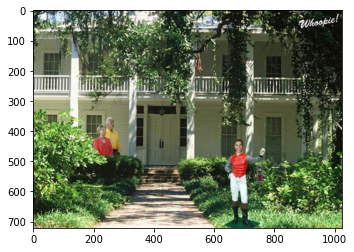

In [ ]:
img_raw = plt.imread(test_images[20])
print(img_raw.shape)

plt.imshow(img_raw)
plt.show()

In [ ]:
img_height_raw, img_width_raw, _ = img_raw.shape

img_height_raw, img_width_raw

(721, 1024)

In [ ]:
# pad input image to avoid unmatched shape problem
img, pad_params = pad_input_image(img_raw, max_steps=max(cfg['steps']))

img.shape, pad_params

((736, 1024, 3), (721, 1024, 15, 0))

In [ ]:
img = np.expand_dims(img, axis=0)

img.shape

(1, 736, 1024, 3)

In [ ]:
model_output = loaded_model(img)
model_output

[<tf.Tensor: shape=(1, 30912, 4), dtype=float32, numpy=
 array([[[ 2.4091911 ,  0.85605067, -2.1499546 , -0.9312115 ],
         [ 0.9455743 , -1.2126769 , -4.0159283 , -2.8294528 ],
         [-0.51167274, -0.20609264, -1.1579263 , -2.9058728 ],
         ...,
         [ 4.8369584 ,  5.475589  , -6.619047  ,  8.047567  ],
         [ 6.9897923 ,  4.680437  ,  0.3754875 ,  4.5837784 ],
         [ 6.9445906 ,  3.0363004 , -6.4932475 ,  5.640929  ]]],
       dtype=float32)>, <tf.Tensor: shape=(1, 30912, 2), dtype=float32, numpy=
 array([[[9.9901319e-01, 9.8675059e-04],
         [9.9976557e-01, 2.3445103e-04],
         [9.9967420e-01, 3.2586430e-04],
         ...,
         [1.0000000e+00, 1.7032691e-14],
         [1.0000000e+00, 3.4113678e-12],
         [1.0000000e+00, 9.2757689e-15]]], dtype=float32)>]

In [ ]:
#preds
preds = tf.concat(
    [model_output[0][0],
    tf.ones_like(model_output[1][0, :, 0][..., tf.newaxis]),
    model_output[1][0, :, 1][..., tf.newaxis]],
    axis = 1
)

preds.shape

TensorShape([30912, 6])

In [ ]:
# tf.shape(inputs)[1] = 640

In [ ]:
img.shape

(1, 736, 1024, 3)

In [ ]:
priors = prior_box_tf((img.shape[1], img.shape[2]),
                      cfg['min_sizes'],  cfg['steps'], cfg['clip'])

type(priors)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
priors

<tf.Tensor: shape=(30912, 4), dtype=float32, numpy=
array([[0.00390625, 0.00543478, 0.015625  , 0.02173913],
       [0.00390625, 0.00543478, 0.03125   , 0.04347826],
       [0.01171875, 0.00543478, 0.015625  , 0.02173913],
       ...,
       [0.953125  , 0.9782609 , 0.5       , 0.6956522 ],
       [0.984375  , 0.9782609 , 0.25      , 0.3478261 ],
       [0.984375  , 0.9782609 , 0.5       , 0.6956522 ]], dtype=float32)>

In [ ]:
decode_preds = decode_tf(preds, priors, cfg['variances'])

type(decode_preds)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
decode_preds

<tf.Tensor: shape=(30912, 6), dtype=float32, numpy=
array([[ 2.5884626e-03, -1.7267647e-03,  1.2752760e-02,  1.6318290e-02,
         1.0000000e+00,  9.8675059e-04],
       [-1.3726531e-04, -1.2182383e-02,  1.3859605e-02,  1.2506932e-02,
         1.0000000e+00,  2.3445103e-04],
       [ 4.7218003e-03, -1.0919529e-03,  1.7116724e-02,  1.1065463e-02,
         1.0000000e+00,  3.2586430e-04],
       ...,
       [ 1.1284430e+00, -3.8009059e-01,  1.2615027e+00,  3.0984335e+00,
         1.0000000e+00,  1.7032691e-14],
       [ 1.0243711e+00,  7.0607388e-01,  1.2938685e+00,  1.5760435e+00,
         1.0000000e+00,  3.4113678e-12],
       [ 1.2633795e+00,  1.1468327e-01,  1.3998295e+00,  2.2642803e+00,
         1.0000000e+00,  9.2757689e-15]], dtype=float32)>

In [ ]:
iou_th = .5
# score_th = .02
score_th = .5
vis_th = .5

In [ ]:
selected_indices = tf.image.non_max_suppression(
        boxes = decode_preds[:, :4],
        scores = decode_preds[:, -1],
        max_output_size = tf.shape(decode_preds)[0],
        iou_threshold = iou_th,
        score_threshold = score_th)

In [ ]:
selected_indices

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([14507, 12095, 12857], dtype=int32)>

In [ ]:
out = tf.gather(decode_preds, selected_indices)
out

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0.65284616, 0.591555  , 0.6776728 , 0.63514435, 1.        ,
        0.9999577 ],
       [0.24115784, 0.49389896, 0.2622423 , 0.5319296 , 1.        ,
        0.9893727 ],
       [0.21433829, 0.5308778 , 0.23655133, 0.57199347, 1.        ,
        0.68610364]], dtype=float32)>

In [ ]:
out = out.numpy()
out.shape

(3, 6)

In [ ]:
for o in out:
  print(o.shape)
  print(o)
  print('*'*50)

(6,)
[0.65284616 0.591555   0.6776728  0.63514435 1.         0.9999577 ]
**************************************************
(6,)
[0.24115784 0.49389896 0.2622423  0.5319296  1.         0.9893727 ]
**************************************************
(6,)
[0.21433829 0.5308778  0.23655133 0.57199347 1.         0.68610364]
**************************************************


In [ ]:
output = pad_landm(out)
output.shape

(3, 16)

In [ ]:
# recover padding effect
outputs = recover_pad_output(output, pad_params)
outputs.shape

(3, 16)

In [ ]:
outputs = recover_pad_landm(outputs)
outputs.shape

(3, 6)

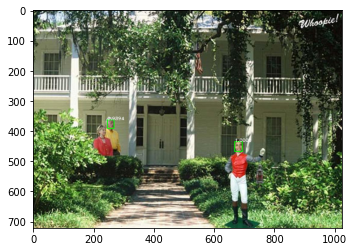

In [ ]:
plt.imshow(img_raw.astype(np.uint8))
plt.show()

In [ ]:
for o in outputs:
  print(o)

[0.65284616 0.60386197 0.6776728  0.64835817 1.         0.99995768]
[0.24115784 0.50417425 0.26224229 0.54299611 1.         0.98937267]
[0.21433829 0.54192244 0.23655133 0.58389347 1.         0.68610364]


In [ ]:
for o in outputs:
  draw_bbox(img_raw, o, img_height_raw, img_width_raw)

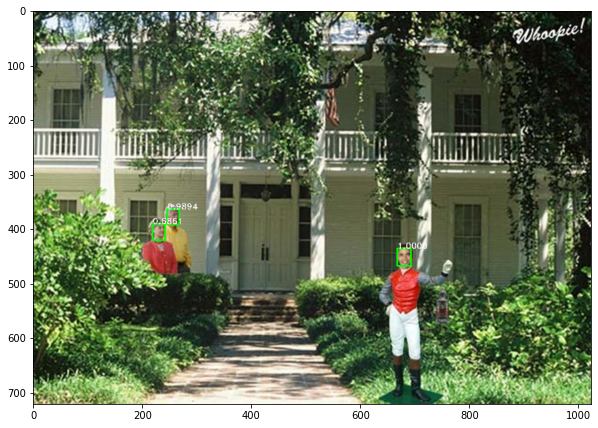

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(img_raw.astype(np.uint8))
plt.show()

In [157]:
# sample_no = test_images.index(test_folder + '59--people--driving--car/59_peopledrivingcar_peopledrivingcar_59_114.jpg')
# sample_no

13833

In [169]:
sample_no = np.random.choice(len(test_images))
print(sample_no)
print(test_images[sample_no])

341
/content/data/WIDER_test/images/54--Rescue/54_Rescue_firemanrescue_54_527.jpg


(760, 1024, 3)


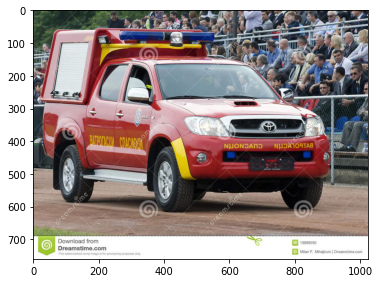

In [170]:
plt.figure(figsize=(6,8))
img_raw = plt.imread(test_images[sample_no])
print(img_raw.shape)

plt.imshow(img_raw)
plt.show()

In [171]:
img_height_raw,img_width_raw, _ = img_raw.shape

In [172]:
outputs = predict_image(test_images[sample_no], iou_th=.3, score_th=.7)
outputs.shape

(27, 6)

In [173]:
for o in outputs:
  draw_bbox(img_raw, o, img_height_raw, img_width_raw)

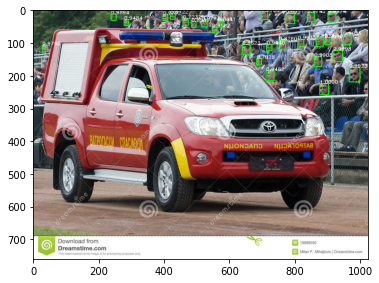

In [174]:
plt.figure(figsize=(6,8))
plt.imshow(img_raw)
plt.show()

Imgae: /content/data/WIDER_test/images/47--Matador_Bullfighter/47_Matador_Bullfighter_matadorbullfighting_47_435.jpg
Output shape: (2, 6)


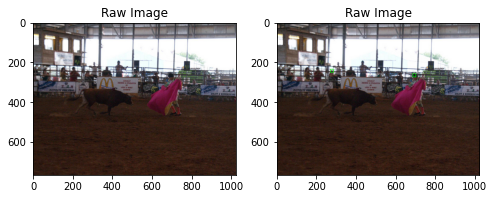

Imgae: /content/data/WIDER_test/images/19--Couple/19_Couple_Couple_19_117.jpg
Output shape: (9, 6)


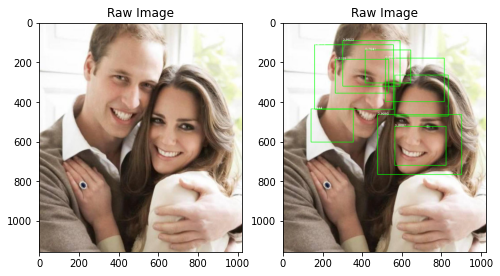

Imgae: /content/data/WIDER_test/images/50--Celebration_Or_Party/50_Celebration_Or_Party_houseparty_50_7.jpg
Output shape: (6, 6)


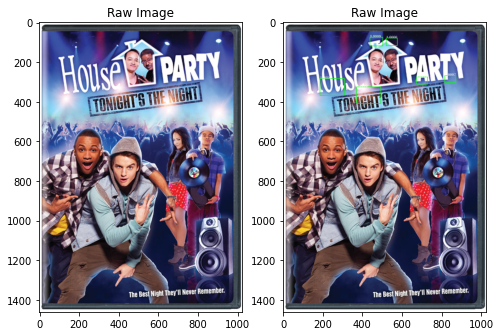

Imgae: /content/data/WIDER_test/images/16--Award_Ceremony/16_Award_Ceremony_Awards_Ceremony_16_586.jpg
Output shape: (1, 6)


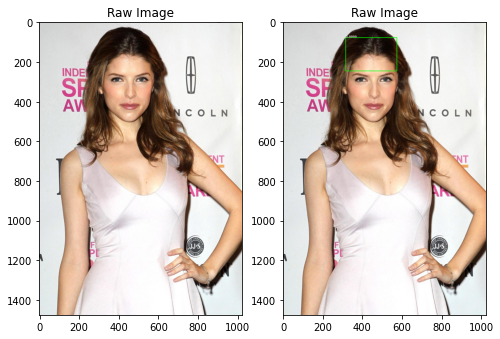

Imgae: /content/data/WIDER_test/images/46--Jockey/46_Jockey_Jockey_46_544.jpg
Output shape: (1, 6)


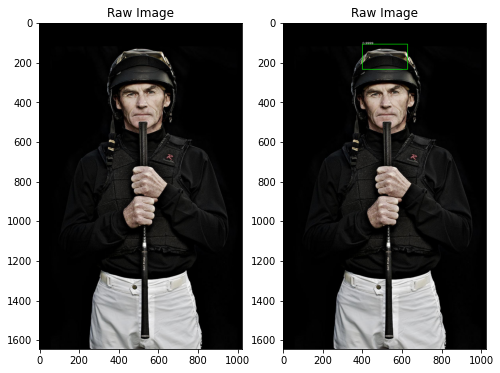

In [ ]:
sample_nos = np.random.choice(len(test_images),5)

for sample_no in sample_nos:
  print('Imgae:', test_images[sample_no])
  img_raw = plt.imread(test_images[sample_no])

  plt.figure(figsize=(8,8))

  plt.subplot(121)
  plt.imshow(img_raw)
  plt.title('Raw Image')

  outputs = predict_image(test_images[sample_no])
  print('Output shape:',outputs.shape)

  for o in outputs:
    draw_bbox(img_raw, o, img_height_raw, img_width_raw)
  
  plt.subplot(122)
  plt.imshow(img_raw)
  plt.title('Raw Image')
  plt.show()

# Quantization

In [ ]:
# load json and create model
with open("/content/drive/MyDrive/RetinaFace/Modified/model_modified_for_training.json", 'r') as json_file:
    model_json = json_file.read()

# load weights into new model
loaded_model = tf.keras.models.model_from_json(model_json)
loaded_model.load_weights("/content/drive/MyDrive/RetinaFace/Modified/model_modified_Training_epoch6.h5")

loaded_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv_1 (TFOpLambda)  (None, 640, 640, 3)  0          ['input_image[0][0]']            
                                                                                                  
 tf.math.subtract_1 (TFOpLambda  (None, 640, 640, 3)  0          ['tf.math.truediv_1[0][0]']      
 )                                                                                                
                                                                                            

In [ ]:
loaded_model.save("/content/drive/MyDrive/RetinaFace/Modified/saved_model_modified_Training_epoch6_train")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/RetinaFace/Modified/saved_model_modified_Training_epoch6_train/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RetinaFace/Modified/saved_model_modified_Training_epoch6_train/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


## tflite - **Without quantization**

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("/content/drive/MyDrive/RetinaFace/Modified/saved_model_modified_Training_epoch6_train")
tflite_model = converter.convert()

In [ ]:
open("/content/drive/MyDrive/RetinaFace/Modified/tflite/model_modified_Training_epoch6_without_quant.tflite", "wb").write(tflite_model)

7389376

In [ ]:
type(tflite_model)

bytes

In [ ]:
len(tflite_model)

7393440

In [ ]:
len(tflite_model)/1000_000

7.39344

In [112]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path = "/content/drive/MyDrive/RetinaFace/Modified/tflite/model_modified_Training_epoch6_without_quant.tflite")
interpreter.allocate_tensors()

In [ ]:
dir(interpreter)

In [26]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [27]:
input_details

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'serving_default_input_image:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([  1, 640, 640,   3], dtype=int32),
  'shape_signature': array([ -1, 640, 640,   3], dtype=int32),
  'sparsity_parameters': {}}]

In [28]:
output_details

[{'dtype': numpy.float32,
  'index': 277,
  'name': 'StatefulPartitionedCall:1',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([    1, 16800,     4], dtype=int32),
  'shape_signature': array([   -1, 16800,     4], dtype=int32),
  'sparsity_parameters': {}},
 {'dtype': numpy.float32,
  'index': 275,
  'name': 'StatefulPartitionedCall:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([    1, 16800,     2], dtype=int32),
  'shape_signature': array([   -1, 16800,     2], dtype=int32),
  'sparsity_parameters': {}}]

In [29]:
#sample_no = np.random.choice(len(test_images))
sample_no = 10009
print(sample_no)
print(test_images[sample_no])

10009
/content/data/WIDER_test/images/13--Interview/13_Interview_Interview_Sequences_13_338.jpg


(423, 1024, 3)


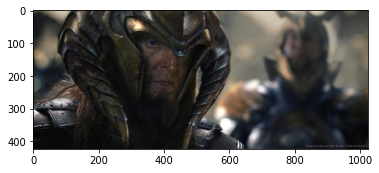

In [30]:
plt.figure(figsize=(6,8))
img_raw = plt.imread(test_images[sample_no])
print(img_raw.shape)

plt.imshow(img_raw)
plt.show()

In [35]:
img = tf.image.resize_with_pad(img_raw, 640, 640, antialias=True)
img = img.numpy()
print(img.shape)


(640, 640, 3)


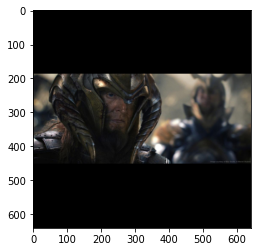

In [37]:
plt.imshow(img.astype(np.uint8))
plt.show()

In [38]:
sample_input = np.expand_dims(img, axis=0)
sample_input.shape

(1, 640, 640, 3)

In [39]:
# Test model on input data.
interpreter.set_tensor(input_details[0]['index'], sample_input)

interpreter.invoke()

In [40]:
# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data1 = interpreter.get_tensor(output_details[0]['index'])
output_data2 = interpreter.get_tensor(output_details[1]['index'])

In [41]:
print(output_data1)

[[[  0.5611348   -0.75551814  -2.6018922   -2.4697943 ]
  [  0.5558319   -2.9429195   -3.4725127   -1.8835695 ]
  [ -0.43540585  -0.55623716  -0.929154    -3.3649862 ]
  ...
  [  4.2630444    5.365354   -11.954863    -0.1789119 ]
  [ 10.603583    -1.9633528   -2.2983286    8.142661  ]
  [  7.3339853    1.8215629  -16.000845     3.2500005 ]]]


In [42]:
output_data1.shape

(1, 16800, 4)

In [43]:
print(output_data2)

[[[9.9798274e-01 2.0172035e-03]
  [9.9871027e-01 1.2897330e-03]
  [9.9830294e-01 1.6970654e-03]
  ...
  [1.0000000e+00 2.3725493e-13]
  [1.0000000e+00 3.9871590e-16]
  [1.0000000e+00 1.7522423e-18]]]


In [44]:
output_data2.shape

(1, 16800, 2)

In [45]:
out_pred = [output_data1, output_data2]

In [56]:
outputs = process_output_image_tflite(out_pred)
outputs

array([[0.28176424, 0.31559923, 0.48101518, 0.56220436, 1.        ,
        0.99067187]])

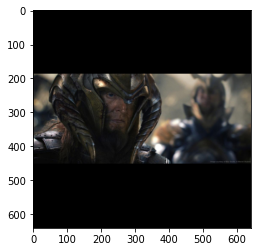

In [57]:
plt.imshow(img.astype(np.uint8))
plt.show()

In [59]:
for o in outputs:
  draw_bbox(img, o, 640, 640)

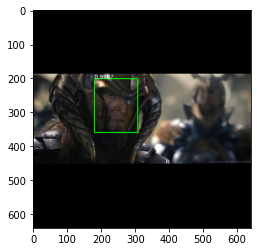

In [60]:
plt.imshow(img.astype(np.uint8))
plt.show()

In [ ]:
#sample_no = np.random.choice(len(test_images))
#sample_no = 10009
print(sample_no)
print(test_images[sample_no])

In [175]:
sample_no = test_images.index(test_folder + '54--Rescue/54_Rescue_firemanrescue_54_527.jpg')
sample_no

341

(760, 1024, 3)


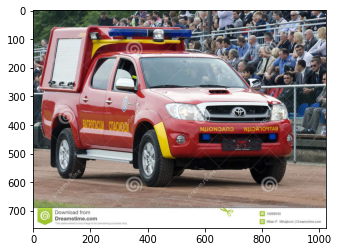

In [176]:
img_raw = plt.imread(test_images[sample_no])
print(img_raw.shape)

plt.imshow(img_raw)
plt.show()

In [177]:
img, out_pred = predict_image_tflite(interpreter, img_raw)

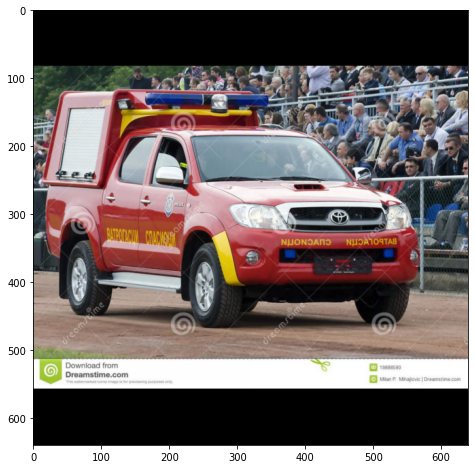

In [178]:
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.show()

In [179]:
out_pred[0].shape, out_pred[1].shape

((1, 16800, 4), (1, 16800, 2))

In [180]:
outputs = process_output_image_tflite(out_pred, iou_th = .1, score_th = .1)
outputs

array([[0.85567117, 0.3467125 , 0.8817034 , 0.38070747, 1.        ,
        0.99951386],
       [0.8962967 , 0.24917418, 0.9233083 , 0.2826531 , 1.        ,
        0.99545383],
       [0.94449425, 0.2983504 , 0.9773301 , 0.3393494 , 1.        ,
        0.98571694],
       [0.84130913, 0.26619896, 0.86424464, 0.2941247 , 1.        ,
        0.98503333],
       [0.73571754, 0.21958645, 0.7567166 , 0.24679627, 1.        ,
        0.95425713],
       [0.6326748 , 0.23168187, 0.6538211 , 0.25777382, 1.        ,
        0.90844566],
       [0.69937044, 0.30596915, 0.72169083, 0.33298364, 1.        ,
        0.9017316 ],
       [0.7534081 , 0.14189333, 0.7742336 , 0.16674736, 1.        ,
        0.8991716 ],
       [0.68229985, 0.13413471, 0.69937646, 0.15658504, 1.        ,
        0.88518685],
       [0.5301904 , 0.23177561, 0.5510238 , 0.2579959 , 1.        ,
        0.8218561 ],
       [0.7160579 , 0.33046198, 0.74014926, 0.36124063, 1.        ,
        0.80129904],
       [0.9284546 , 0

In [181]:
for o in outputs:
  draw_bbox(img, o, 640, 640)

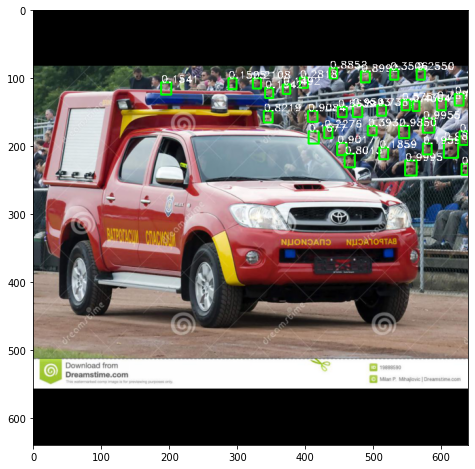

In [182]:
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.show()

## tflite - **With quantization**

In [186]:
converter = tf.lite.TFLiteConverter.from_saved_model("/content/drive/MyDrive/RetinaFace/Modified/saved_model_modified_Training_epoch6_train")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [187]:
open("/content/drive/MyDrive/RetinaFace/Modified/tflite/model_modified_Training_epoch6_with_quant.tflite", "wb").write(tflite_quant_model)

2274736

In [188]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path = "/content/drive/MyDrive/RetinaFace/Modified/tflite/model_modified_Training_epoch6_with_quant.tflite")
interpreter.allocate_tensors()

In [189]:
type(tflite_quant_model)

bytes

In [190]:
len(tflite_quant_model)

2274736

In [191]:
len(tflite_quant_model)/1000_000

2.274736

In [202]:
# Load TFLite model and allocate tensors.
quant_interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/RetinaFace/Modified/tflite/model_modified_Training_epoch6_with_quant.tflite")
quant_interpreter.allocate_tensors()

In [193]:
# Get input and output tensors.
input_details = quant_interpreter.get_input_details()
output_details = quant_interpreter.get_output_details()

In [194]:
input_details

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'serving_default_input_image:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([  1, 640, 640,   3], dtype=int32),
  'shape_signature': array([ -1, 640, 640,   3], dtype=int32),
  'sparsity_parameters': {}}]

In [195]:
output_details

[{'dtype': numpy.float32,
  'index': 277,
  'name': 'StatefulPartitionedCall:1',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([    1, 16800,     4], dtype=int32),
  'shape_signature': array([   -1, 16800,     4], dtype=int32),
  'sparsity_parameters': {}},
 {'dtype': numpy.float32,
  'index': 275,
  'name': 'StatefulPartitionedCall:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([    1, 16800,     2], dtype=int32),
  'shape_signature': array([   -1, 16800,     2], dtype=int32),
  'sparsity_parameters': {}}]

In [247]:
img_name = '43--Row_Boat/43_Row_Boat_Rowboat_43_772.jpg'
sample_no = test_images.index(test_folder + img_name)
sample_no

12605

(681, 1024, 3)


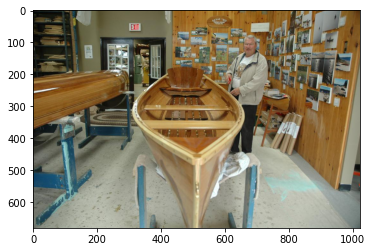

In [248]:
img_raw = plt.imread(test_images[sample_no])
print(img_raw.shape)

plt.imshow(img_raw)
plt.show()

In [249]:
img, out_pred = predict_image_tflite(quant_interpreter, img_raw)

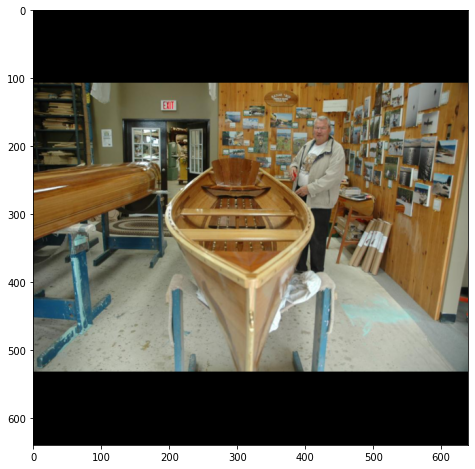

In [250]:
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.show()

In [251]:
out_pred[0].shape, out_pred[1].shape

((1, 16800, 4), (1, 16800, 2))

In [252]:
outputs = process_output_image_tflite(out_pred)    #, iou_th = .1, score_th = .1)
outputs

array([[0.6439608 , 0.25573793, 0.6777715 , 0.29830274, 1.        ,
        0.9965784 ]], dtype=float32)

In [253]:
for o in outputs:
  draw_bbox(img, o, 640, 640)


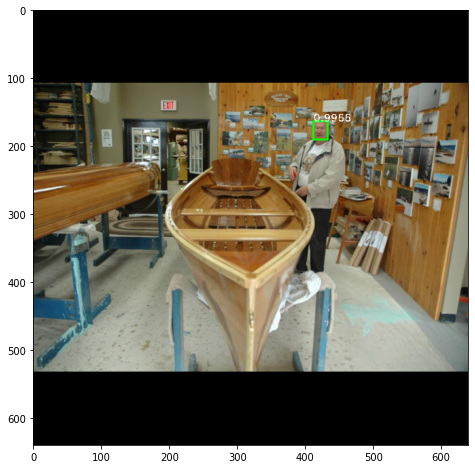

In [254]:
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.show()

# END